## Solve LQG B Eq. using WENO recontruction method

We solve the eq.
$$
\partial_t B(x, t) + \partial_x f(B) = 0, \qquad f(B) = \frac{1}{2} x^3 \sin^2 \left( \frac{B}{x^2} \right) 
$$
using WENOr2 and WENOr3 reconstruction methods to capture shocks in the B(x,t) field.

$$
\partial_B f(B) = \frac{1}{2} x \sin(2\frac{B}{x^2})
$$

### Initial data:

$$
B(x, 0) = - \frac{x^2}{2} \arccos\left( 1 - 4\frac{M(x)}{x^3} \right), \qquad M(x) = 4\pi\int_0^x \rho(y)y^2 dy 
$$
where
$$
\rho(x) = \frac{m}{\frac{4}{3}\pi r_0^3} \left( 1 - \theta(x - r_0)  \right), \quad \theta = \begin{cases} 0&\text{ if }x \leq r_0\\1&\text{ if }x \gt r_0\end{cases}
$$
and $m = 5$, $r_0 = 15$.

In [1]:
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
from numba import njit, vectorize

%matplotlib widget

@njit
def f(u, x):
    return 0.5 * x*x*x * np.sin(u / x/x)**2 

@njit
def fp(u, x, h):
    return 0.5 * x * np.sin(2 * u /x/x)

# @njit
# def u_der(f, h):
#     f_x = np.zeros_like(f)
#     f_x[0:2] = (-25*f[0:2]/12+4*f[1:3]-3*f[2:4]+4*f[3:5]/3-f[4:6]/4)/h
#     f_x[-2:] = (25*f[-2:]/12-4*f[-3:-1]+3*f[-4:-2]-4*f[-5:-3]/3+f[-6:-4]/4)/h
#     f_x[2:-2] = (f[0:-4]-8*f[1:-3]+8*f[3:-1]-f[4:])/(12*h)
#     return f_x

In [2]:
def initial_data(xs, m, r0):

    rho = 3 * m * (1 - heaviside(xs, r0)) / (4 * np.pi * r0**3)
    # rho = np.exp(-2*(xs-1.5*m)**2)/5 + np.exp(-4*(xs-3.5*m)**2)/10


    M = 4*np.pi * cumulative_trapezoid(rho * xs*xs, xs, initial = 0)
    print(f'Mass computed at infinity = {np.round(M[-1],3)}')
    
    B0 = - 0.5 * xs*xs * np.arccos(1 - 4 * M / xs/xs/xs)
    # B0[0] = 0
    return B0

@vectorize
def heaviside(x, a):
    if x <= a:
        return 0
    else:
        return 1

In [3]:
@njit
def TDV_RK(r, u_prev, fup, xs, h, dt, nghost):
    if r == 2:
        return TDV_RK3(u_prev, xs, fup, h, dt, nghost)
    elif r == 3:
        return TDV_RK4(u_prev, xs, fup, h, dt, nghost)
    else:
        raise Exception("Order not implemented! r = 2 or 3")

@njit
def L(r, j, u, fup, xs, h, nghost):
    """
    Equation 2.7b

    u  --> array of sol
    xs --> array of grid
    
    x_jm = x_{j - 1/2}
    x_jM = x_{j + 1/2}
    """
    x_jM = xs[j] + h / 2
    x_jm = xs[j] - h / 2
    if j == nghost:
        o1 = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2 = 0
    else:
        o1 = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2 = flux( R(r, j-1, x_jm, u, fup, xs, h), R(r, j  , x_jm, u, fup, xs, h), x_jm)
    return - ( o1 - o2 ) / h

@njit
def R(r, j, x_pt, u, fup, xs, h):
    if r == 2:
        return R2(j, x_pt, u, fup, xs, h)
    elif r == 3:
        return R3(j, x_pt, u, fup, xs, h)

@njit
def alpha(r, j, i, u, fup, x, h):
    if r == 2:
        return alpha_r2(j, i, u, fup, x, h)
    elif r == 3:
        return alpha_r3(j, i, u, fup, x, h)

@njit
def interpolants(r, j, x, u, xs, h):
    if r == 2:
        return interp_r2(j, x, u, xs, h)
    elif r == 3:
        return interp_r3(j, x, u, xs, h)

@njit
def SI(r, j, u):
    if r == 2:
        return SI_r2(j, u)
    elif r == 3:
        return SI_r3(j, u)

# @njit
# def flux(a, b, x):
#     """
#     Godunov flux function
#     Equation 2.5
#     """
#     u_dec = np.linspace(min(a,b), max(a,b), 100)
#     if a <= b:
#         return min(f(u_dec, x))
#     elif a > b:
#         return max(f(u_dec, x))
        
@njit
def flux(a, b, x):
    ul = a/x/x
    ur = b/x/x
    FL = 0.5 * x**3 * np.sin(ul)**2 
    FR = 0.5 * x**3 * np.sin(ur)**2 
    ll = np.array([FL, FR])
    if ul <= ur:
        return np.min(ll)
    elif ul > ur:
        if ((ur > -np.pi/2) or (ul < -np.pi/2)):
            return np.max(ll)
        else:
            return 0.5 * x**3


@njit
def BC(arr, nghost):
    arr[:nghost] = arr[nghost]
    arr[-nghost:] = arr[-nghost - 1]
    return arr


In [4]:
@njit
def TDV_RK3(u_prev, xs, fup, h, dt, nghost):
    """
    ## TO OPTIMIZE

    1**) Euler step t      --> t +   dt
    2**) Euler step t + dt --> t + 2*dt
    
    3**) Weighted mean btw t and t+2*dt to find t + dt/2
    
    4**) Euler step t + dt/2 -- > t + 3*dt/2
    
    5**) Weighted mean btw t and t+3*dt/2 to find  t + dt
    """
    rr = np.zeros(len(u_prev) - 2*nghost)
    u_n1    = np.zeros_like(u_prev)
    u_n2    = np.zeros_like(u_prev)
    u_n12   = np.zeros_like(u_prev)
    u_n32   = np.zeros_like(u_prev)
    u_final = np.zeros_like(u_prev)

    # 1**)
    for j in range(len(rr)-1):
        rr[j] = L(2, j+nghost, u_prev, fup, xs, h, nghost)
    u_n1[nghost] = 0
    u_n1[nghost+1:-nghost] = u_prev[nghost+1:-nghost] + dt * rr[1:]
    u_n1 = BC(u_n1, nghost)

    # 2**)
    for j in range(len(rr)-1):
        rr[j] = L(2, j+nghost, u_n1, fup, xs, h, nghost)
    u_n2[nghost] = 0
    u_n2[nghost+1:-nghost] = u_n1[nghost+1:-nghost] + dt * rr[1:]
    u_n2 = BC(u_n2, nghost)

    # 3**)
    u_n12[nghost] = 0
    u_n12[nghost+1:-nghost] = 3 * u_prev[nghost+1:-nghost] / 4 + u_n2[nghost+1:-nghost] / 4
    u_n12 = BC(u_n12, nghost)

    # 4**)
    for j in range(len(rr)-1):
        rr[j] = L(2, j+nghost, u_n12, fup, xs, h, nghost)
    u_n32[nghost] = 0
    u_n32[nghost+1:-nghost] = u_n12[nghost+1:-nghost] + dt * rr[1:]
    u_n32 = BC(u_n32, nghost)

    # 5**)
    u_final[nghost] = 0
    u_final[nghost+1:-nghost] = u_prev[nghost+1:-nghost] / 3 + 2 * u_n32[nghost+1:-nghost] / 3
    return BC(u_final, nghost)
    
@njit
def R2(j, x_pt, u, fup, xs, h):
    """
    Equation 3.16
    """
    aj0 = alpha(2, j, 0, u, fup, x_pt, h)
    aj1 = alpha(2, j, 1, u, fup, x_pt, h)
    d = aj0 + aj1
    r1 = aj0 / d
    r2 = aj1 / d
    out = r1 * interpolants(2, j, x_pt, u, xs, h) + r2 * interpolants(2, j+1, x_pt, u, xs, h)
    return out

@njit
def alpha_r2(j, i, u, fup, x, h, eps = 1e-6):
    """
    Equations 3.17a & 3.17b 
    """
    if fup[j-1] > 0:
        if i == 0:
            return 1 / 2 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / (eps + SI(2, j+1, u))**2
    elif fup[j-1] <= 0:
        if i == 0:
            return 1 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / 2 / (eps + SI(2, j+1, u))**2

@njit
def interp_r2(j, x, u, xs, h):
    return u[j-1] + (u[j] - u[j-1]) * (x - xs[j-1]) / h

@njit
def SI_r2(j, u):
    return (u[j] - u[j-1])**2

In [5]:
@njit
def TDV_RK4(u_prev, xs, fup, h, dt, nghost):
    """
    uj_0 = u_prev[j]
    uj_1 = uj_0 + dt * L(uj_0)
    uj_2 = uj_0 / 2 + u_j1 / 2 - dt * L(u_j1) / 4 + dt * L(u_j2) / 2
    u_j3 = uj_0 / 9 + 2 * u_j1 / 9 + 2 * u_j2 / 3 - dt * L(u_j1) / 9 - dt * L(u_j2) / 3 + dt * L(u_j3)
    u_new = u_j1 / 3 + u_j2 / 3 + u_j3 / 3 + dt * L(u_j2) / 6 + dt * L(u_j3) / 6
    """

    r_j1 = np.zeros(len(u_prev) - 2*nghost)
    r_j2 = np.zeros(len(u_prev) - 2*nghost)
    r_j3 = np.zeros(len(u_prev) - 2*nghost)

    u_j1    = np.zeros_like(u_prev)
    u_j2    = np.zeros_like(u_prev)
    u_j3    = np.zeros_like(u_prev)
    u_final = np.zeros_like(u_prev)

    for j in range(len(r_j1)-2):
        r_j1[j] = L(3, j+nghost, u_prev, fup, xs, h, nghost)
    u_j1[nghost] = 0
    u_j1[nghost+1:-nghost] = u_prev[nghost+1:-nghost] + dt*r_j1[1:]
    u_j1 = BC(u_j1, nghost)

    for j in range(len(r_j2)-2):
        r_j2[j] = L(3, j+nghost, u_j1, fup, xs, h, nghost)
    u_j2[nghost] = 0
    u_j2[nghost+1:-nghost] = u_prev[nghost+1:-nghost] / 2 + u_j1[nghost+1:-nghost] / 2 - dt*r_j1[1:] / 4 + dt * r_j2[1:] / 2
    u_j2 = BC(u_j1, nghost)

    for j in range(len(r_j3)-2):
        r_j3[j] = L(3, j+nghost, u_j2, fup, xs, h, nghost)
    u_j3[nghost] = 0
    u_j3[nghost+1:-nghost] = u_prev[nghost+1:-nghost]/9 + 2*u_j1[nghost+1:-nghost]/9 + 2*u_j2[nghost+1:-nghost]/3 - dt*r_j1[1:]/9 - dt*r_j2[1:]/3 + dt*r_j3[1:]
    u_j3 = BC(u_j1, nghost)

    u_final[nghost] = 0
    u_final[nghost+1:-nghost] = u_j1[nghost+1:-nghost]/3 + u_j2[nghost+1:-nghost]/3 + u_j3[nghost+1:-nghost]/3 + dt*r_j2[1:]/6 + dt*r_j3[1:]/6
    return BC(u_final, nghost)

@njit
def R3(j, x_pt, u, fup, xs, h):
    """
    Equation 3.18
    """
    aj0 = alpha(3, j, 0, u, fup, x_pt, h)
    aj1 = alpha(3, j, 1, u, fup, x_pt, h)
    aj2 = alpha(3, j, 2, u, fup, x_pt, h)
    d = aj0 + aj1 + aj2
    r1 = aj0 / d
    r2 = aj1 / d
    r3 = aj2 / d
    out = r1 * interpolants(3, j, x_pt, u, xs, h) + r2 * interpolants(3, j+1, x_pt, u, xs, h) + r3 * interpolants(3, j+2, x_pt, u, xs, h)
    return out

@njit
def alpha_r3(j, i, u, fup, x, h, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    if fup[j-2] > 0:
        if i == 0:
            return 1 / 12 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 4 / (eps + SI(3, j+2, u))**3
    elif fup[j-2] <= 0:
        if i == 0:
            return 1 / 4 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 12 / (eps + SI(3, j+2, u))**3

@njit
def interp_r3(j, x, u, xs, h):
    p1 = (u[j] - 2*u[j-1] + u[j-2]) * (x - xs[j-1])*(x - xs[j-1]) / 2 / h/h 
    p2 = (u[j] - u[j-2]) * (x - xs[j-1]) / 2 / h
    p3 = u[j-1] - (u[j] - 2*u[j-1] + u[j-2]) / 24

    return p1 + p2 + p3

@njit
def SI_r3(j, u):
    p1 = (u[j-1] - u[j-2])**2
    p2 = (u[j] - u[j-1])**2
    p3 = (u[j] - 2*u[j-1] + u[j-2])**2

    return 0.5*(p1 + p2) + p3

In [6]:
@njit
def CLF(u, xs, dx, fact = 0.45):
    # Set dt using velocity of characteristics
    vel = xs * np.sin(u / xs/xs) * np.cos(u / xs/xs)
    v = np.max(np.array([-np.min(vel), np.max(vel)]))

    # CFL condition
    dt = fact * dx / np.abs(v)
    if dt > 0.02:
       dt = 0.02  # largest timestep allowed
    return dt

# @njit
# def CLF(u, xs, dx, fact = 0.45):
#     # Set dt using velocity of characteristics
#     vel = xs * np.sin(u / xs**2) * np.cos(u / xs**2)
#     v_abs = np.abs(vel).max()

#     # Compute dt
#     dt = fact * dx / v_abs
#     if dt > 0.02:  # largest timestep allowed
#         dt = 0.02
#     return dt

In [7]:
from tqdm.notebook import tqdm

r = 2
m = 5
r0 = 15

xM = 50
h = 1e-2
N_it = 3000

if r == 2:
    nghost = 1
elif r == 3:
    nghost = 2

# Grid
nx = int(xM / h + 1 + 2*nghost)
xs = np.array([0.01*h + (i-nghost)*h for i in range(nx)])
x_phys = xs[nghost:-nghost]

# Initial Data
u_p = np.zeros_like(xs)
u_p[nghost:-nghost] = initial_data(x_phys, m, r0)
u_p = BC(u_p, nghost)


# Derivative of f(u)
fup = fp(u_p[nghost:-nghost], x_phys, h)

rhos = np.zeros((len(u_p) - 2*nghost, 2))
Bs = np.zeros_like(rhos)

t = 0
for i in tqdm(range(N_it)):
    # Compute dt
    dt = CLF(u_p[nghost:-nghost], x_phys, h)
    # dt_OG = OG_CLF(u_p[nghost:-nghost], x_phys, h)
    # np.testing.assert_almost_equal(dt_OG, dt)
    # Advance time
    t = t + dt
    # RK timestep
    u = TDV_RK(r, u_p, fup, xs, h, dt, nghost)
    # Compute derivative for next cycle
    fup = fp(u[nghost:-nghost], x_phys, h)

    # Save
    if i == 0:
        Bs[:,0] = u_p[nghost:-nghost].copy()
        rhos[:,0] = (u_p[nghost:-nghost] - u[nghost:-nghost]) / (4*np.pi * dt * x_phys**2)

    # Update old storage variable
    if i != N_it - 1:
        u_p = u.copy()
   
Bs[:,1] = u[nghost:-nghost].copy()
rhos[:,1] = (u_p[nghost:-nghost] - u[nghost:-nghost]) / (4*np.pi * dt * x_phys**2)

Mass computed at infinity = 4.995


  0%|          | 0/3000 [00:00<?, ?it/s]

In [8]:
# def comp_der_loop(f, xs, h):
#     f_x = np.zeros_like(f)
#     for i in range(len(xs)):
#         if i in range(2):
#             f_x[i] = (-25*f[i+0]+48*f[i+1]-36*f[i+2]+16*f[i+3]-3*f[i+4])/(12*1.0*h**1)
#         elif i in range(len(xs) - 2, len(xs)):
#             f_x[i] = (3*f[i-4]-16*f[i-3]+36*f[i-2]-48*f[i-1]+25*f[i+0])/(12*1.0*h**1)
#         else:
#             f_x[i] = (1*f[i-2]-8*f[i-1]+0*f[i+0]+8*f[i+1]-1*f[i+2])/(12*1.0*h**1)
#     return f_x

# def comp_der(f, h):
#     f_x = np.zeros_like(f)
    
#     f_x[0:2] = (-25*f[0:2]/12+4*f[1:3]-3*f[2:4]+4*f[3:5]/3-f[4:6]/4)/h
#     f_x[-2:] = (25*f[-2:]/12-4*f[-3:-1]+3*f[-4:-2]-4*f[-5:-3]/3+f[-6:-4]/4)/h
#     f_x[2:-2] = (f[0:-4]-8*f[1:-3]+8*f[3:-1]-f[4:])/(12*h)

#     return f_x

# np.testing.assert_array_almost_equal(comp_der_loop(sol[:, 1], xs, h), comp_der_v(sol[:, 1], xs, h))

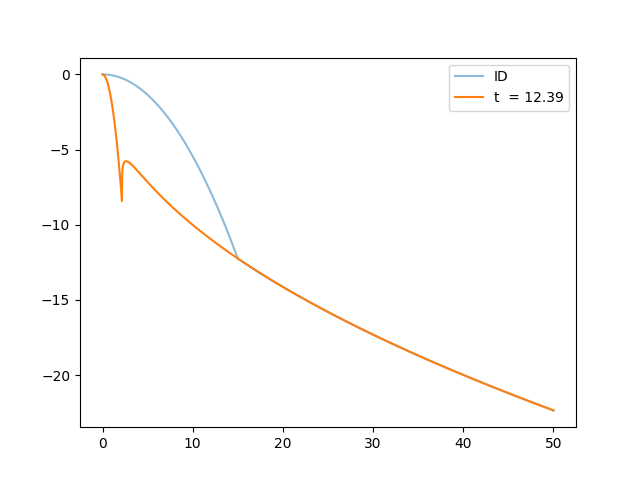

In [9]:
fig = plt.figure()
plt.plot(x_phys, Bs[:, 0], alpha = 0.5, label = 'ID')
plt.plot(x_phys, Bs[:, 1], label = f't  = {np.round(t,2)}')
plt.legend()

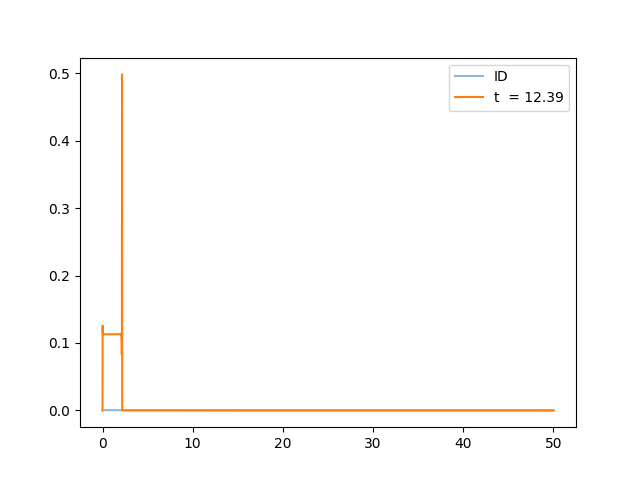

In [10]:
fig = plt.figure()
plt.plot(x_phys, rhos[:, 0],       alpha = 0.5, label = 'ID')
plt.plot(x_phys, rhos[:, 1],       label = f't  = {np.round(t,2)}')
plt.legend()

# plt.ylim(-1e-4, 8e-4)